In [1]:
import numpy as np
import pandas as pd
import sys,os
import pylab
from scipy import stats,signal,io
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import pickle
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import h5py
import matplotlib.gridspec as gridspec
plt.rcParams['pdf.fonttype'] = 'truetype'

In [2]:
os.getcwd()

'/Users/guitchounts/Documents/GitHub/temp_conv_net'

In [3]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(100, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y[::5, :] += (0.5 - rng.rand(20, 2))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [4]:

# Predict
X_test = np.arange(-100.0, 100.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)

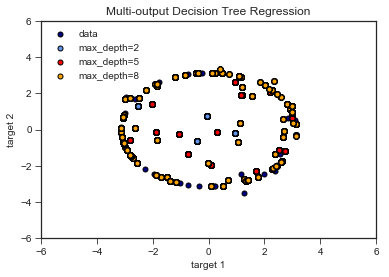

In [5]:

# Plot the results
plt.figure()
s = 25
plt.scatter(y[:, 0], y[:, 1], c="navy", s=s,
            edgecolor="black", label="data")
plt.scatter(y_1[:, 0], y_1[:, 1], c="cornflowerblue", s=s,
            edgecolor="black", label="max_depth=2")
plt.scatter(y_2[:, 0], y_2[:, 1], c="red", s=s,
            edgecolor="black", label="max_depth=5")
plt.scatter(y_3[:, 0], y_3[:, 1], c="orange", s=s,
            edgecolor="black", label="max_depth=8")
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Multi-output Decision Tree Regression")
plt.legend(loc="best")
plt.show()

In [6]:
y.shape

(100, 2)

In [7]:
rat_path = '/Users/guitchounts/Dropbox (coxlab)/Ephys/Data/GRat27/636505101334801062/'

In [11]:
def filter(ephys,freq_range,filt_order = 4,filt_type='bandpass',fs=10.):

    # design Elliptic filter:

    [b,a] = signal.butter(filt_order,[freq/(fs/2) for freq in freq_range],btype=filt_type)

    filtered_trace = signal.filtfilt(b,a,ephys,axis=0)
    return filtered_trace

In [10]:
## get and format data
mua_file = h5py.File(rat_path + 'mua_firing_rates_100hz.hdf5', 'r')
print('mua_file keys:',mua_file.keys())
data_name = list(mua_file.keys())[0]

neural_data = np.asarray(mua_file[data_name]) # iterate through powerbands



print('Shape of neural data, as loaded: ', neural_data.shape)
if neural_data.shape[0] > neural_data.shape[1]:   #### ephys should be channels x samples
    neural_data = neural_data.T


fs = 100.

#tetrodes = grouper(neural_data, neural_data.shape[0]


('mua_file keys:', [u'firing_rates'])
('Shape of neural data, as loaded: ', (712910, 16))


In [12]:
head_signals_h5 = h5py.File(rat_path + 'all_head_data_100hz.hdf5', 'r')
idx_start, idx_stop = [0,9]
head_signals = np.asarray([np.asarray(head_signals_h5[key]) for key in head_signals_h5.keys()][0:9]).T[:,idx_start:idx_stop]
print('head_signals shape: ', head_signals.shape)

## lowpass filter:
for x in range(6,9):
    print('Filtering head signal %s' % list(head_signals_h5.keys())[x])
    head_signals[:,x] = filter(head_signals[:,x],[1],filt_type='lowpass',fs=fs)




head_signals = np.vstack([head_signals[:,6],head_signals[:,7],head_signals[:,8]]).T
print('after NOT decode_signals, head_signals.shape = ',head_signals.shape)
head_signals_int = ['yaw_abs', 'roll_abs', 'pitch_abs']

('head_signals shape: ', (712910, 9))
Filtering head signal ox
Filtering head signal oy
Filtering head signal oz
('after NOT decode_signals, head_signals.shape = ', (712910, 3))


In [13]:
head_signals.shape

(712910, 3)

In [14]:
neural_data.shape

(16, 712910)

In [1]:
import data_helpers

In [ ]:
def determine_fit(X, y, y_key, nn_params,save_dir, plot_result=True,model_type = 'temp_conv'):

    #if y_key[0].find('yaw') == -1:
    custom_loss = 0
    #     print('Training on %s, using MSE as loss function' % y_key[0])
    # else:
    #     custom_loss = 1
    #     print('Training on %s, using custom loss function' % y_key[0])
    
    

    model, X_train, X_test, y_train, y_test = evaluate_timeseries(
        X, 
        y, 
        nn_params,
        custom_loss,
        model_type=model_type
    )
    
    y_test_hat = model.predict(X_test)
    
    if model_type == 'ridge' or model_type == 'lasso':
        # save the model:
        joblib.dump(model, save_dir + str(y_key) + '_%s.pkl' % model_type) 

    R2s, rs = do_the_thing(
        y_test, 
        y_test_hat, 
        y_key, 
        'temp_conv_results_{}_{}'.format(nn_params['id'], y_key),
        save_dir,
        plot_result=plot_result
    )
    
    return R2s, rs

In [2]:
def evaluate_timeseries(timeseries1, timeseries2, nn_params,custom_loss=0,model_type = 'temp_conv'):
    nb_samples, nb_series = timeseries1.shape
    
    if timeseries2.ndim == 1:
        timeseries2 = np.atleast_2d(timeseries2).T
    


    if 'shuffle' in nn_params.keys():
        shuffle = nn_params['shuffle'] ## if the params file has a shuffle key, use it; otherwise set it to False 
    else:
        shuffle = False


    nb_out_samples, nb_out_series = timeseries2.shape

    print('THE SHAPES OF timeseries1, timeseries2 ==== ',timeseries1.shape, timeseries2.shape)    
    X, y = make_timeseries_instances(timeseries1, timeseries2, nn_params['window'], nn_params['offset'])
    print('Shapes of X and y after making timeseries instance:', X.shape,y.shape)


    if 'resample' in nn_params.keys():
        resample = nn_params['resample']
    else:
        resample = 0
        
    if resample == 1:
        print('###################### resampling y ######################')

        sampled_dx_idx = sample_dx_uniformly(y)
        sampled_dx_idx = np.sort(sampled_dx_idx)
        
        y = y[sampled_dx_idx,:]
        X = X[sampled_dx_idx,:,:]
        print('Shapes of X and y after resampling:', X.shape,y.shape)
    
    print(y.shape)
    print(X.shape)


    # non_zeros = np.where(abs(y) > 0.1 )[0]    
    
    # y = y[non_zeros,:]
    # X = X[non_zeros,:,:]
    # pos = np.where(y > 0)[0]
    # neg = np.where(y < 0)[0]
    # y[neg] = -1
    # y[pos] = 1
    #y = Normalizer(norm='l2').fit_transform(np.atleast_2d(y))
    #y = (y - np.mean(y)) / np.std(y)
    
    

    X, y = timeseries_shuffler(X, y, 3000, 25)
    
    if nn_params['verbose']: 
        print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series))
        print('\n\nExample input feature:', X[0], '\n\nExample output labels:', y[0])
    
    if model_type == 'ridge' or model_type == 'lasso':
        print(model_type)
        print('Making Linear %s Model' % model_type)
        model = make_linear_model(model_type=model_type)
        
    else:
        print(model_type)
        print('Making TempConvNet Model')
        model = make_timeseries_regressor(
            nn_params,
            nb_input_series=nb_series, 
            nb_outputs=nb_out_series,
            custom_loss=custom_loss
        )
    

    if nn_params['verbose']: 
        print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape))
        model.summary()
    
    X_train, X_test, y_train, y_test = split_data(X, y, 0.5,shuffle=shuffle)
    
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    # print('###################### resampling y ######################')

    # sampled_dx_idx_train = sample_dx_uniformly(y_train,num_points=5000)
    # sampled_dx_idx_test = sample_dx_uniformly(y_test,num_points=5000)

    # y_train = y_train[sampled_dx_idx_train,:]
    # X_train = X_train[sampled_dx_idx_train,:,:]

    # y_test = y_test[sampled_dx_idx_test,:]
    # X_test = X_test[sampled_dx_idx_test,:,:]
    # print('Shapes of X_train and y_train after resampling:', X_train.shape,y_train.shape)
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=20, 
        verbose=1, 
        mode='auto'
    )

    if model_type == 'ridge' or model_type == 'lasso':
        print('Reshaping X_train and X_test and fitting %s model' % model_type)
        #### X's are (time, window, channels), e.g. (13085, 200, 16). Reshape for the linear model:
        X_train = X_train.reshape(X_train.shape[0],(X_train.shape[1]*X_train.shape[2]))
        X_test = X_test.reshape(X_test.shape[0],(X_test.shape[1]*X_test.shape[2]))
        model.fit(X_train,y_train)

        

    else:
        model.fit(
            X_train, 
            y_train, 
            epochs=nn_params['eps'], 
            batch_size=nn_params['bs'], 
            validation_data=(X_test, y_test),
            callbacks=[early_stopping]
        )

    return model, X_train, X_test, y_train, y_test